In [1]:
import torch
import hiddenlayer as hl 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn

In [2]:
data = pd.read_csv('datasets/bike_sharing.csv', index_col=0)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,spring,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,spring,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,spring,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,spring,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,spring,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
data.shape

(731, 16)

Text(0.5, 1.0, 'number of bikes rented per season')

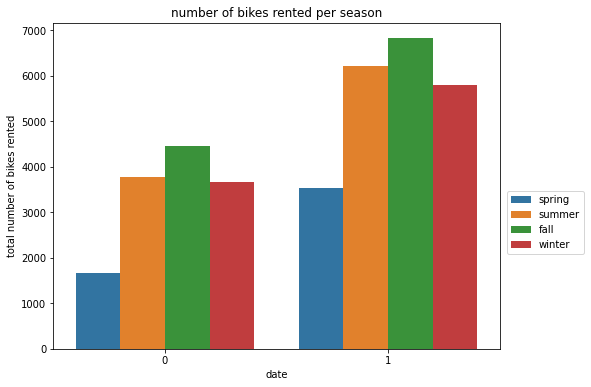

In [4]:
plt.figure(figsize=(8,6))
sns.barplot('yr', 'cnt', hue='season', data=data, ci=None)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

plt.xlabel('date')
plt.ylabel('total number of bikes rented')

plt.title('number of bikes rented per season')

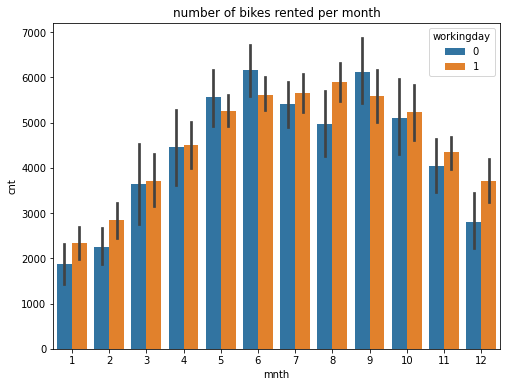

In [5]:
plt.figure(figsize=(8,6))

sns.barplot(x='mnth', y='cnt', hue='workingday', data=data)

plt.title('number of bikes rented per month')
plt.show()

Text(0, 0.5, 'total number of bikes rented')

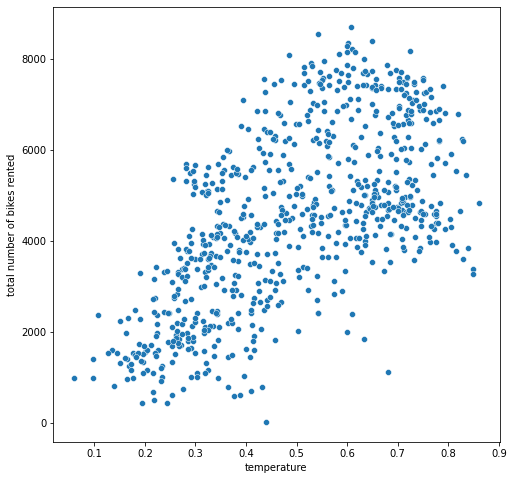

In [6]:
plt.figure(figsize=(8,8))

fig = sns.scatterplot(x='temp',y='cnt',data=data)

plt.xlabel('temperature')
plt.ylabel('total number of bikes rented')

In [7]:
# convert categorical data using one hot encoding
data = pd.get_dummies(data, columns=['season'])

In [8]:
data.sample(5)

,instant,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_fall,season_spring,season_summer,season_winter
226,227,2011-08-15,0,8,0,1,1,1,0.665833,0.616167,0.712083,0.208954,775,3563,4338,1,0,0,0
246,247,2011-09-04,0,9,0,0,0,1,0.709167,0.665429,0.742083,0.206467,2521,2419,4940,1,0,0,0
211,212,2011-07-31,0,7,0,0,0,1,0.805833,0.729796,0.480833,0.164813,1524,2778,4302,1,0,0,0
180,181,2011-06-30,0,6,0,4,1,1,0.696667,0.637008,0.434167,0.185312,1027,4488,5515,1,0,0,0
456,457,2012-04-01,1,4,0,0,0,2,0.425833,0.417287,0.676250,0.172267,2347,3694,6041,0,0,1,0


In [9]:
columns = ['registered', 'holiday', 'weekday', 'weathersit', 'temp', 'atemp', 'season_fall', 'season_spring', 'season_summer', 'season_winter']
features = data[columns]

features.head()

,registered,holiday,weekday,weathersit,temp,atemp,season_fall,season_spring,season_summer,season_winter
0,654,0,6,2,0.344167,0.363625,0,1,0,0
1,670,0,0,2,0.363478,0.353739,0,1,0,0
2,1229,0,1,1,0.196364,0.189405,0,1,0,0
3,1454,0,2,1,0.200000,0.212122,0,1,0,0
4,1518,0,3,1,0.226957,0.229270,0,1,0,0


In [10]:
target = data[['cnt']]
target.head()

,cnt
0,985
1,801
2,1349
3,1562
4,1600


In [11]:
# split our dataset into training and test data

from sklearn.model_selection import train_test_split

In [12]:
X_train, x_test, Y_train, y_test = train_test_split(features,target,test_size=0.2)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)

Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

In [13]:
# splitting training data into batches

import torch.utils.data as data_utils
# used along with PyTorch data loaders which can load multiple samples in parallel
train_data = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)

train_loader = data_utils.DataLoader(train_data, batch_size=100, shuffle=True)
len(train_loader)

6

In [14]:
# select first of the batches
features_batch, target_batch = iter(train_loader).next()

In [15]:
# number of features
inp = X_train_tensor.shape[1]

out = 1
hid = 10

loss_fn = torch.nn.MSELoss()


(dot.exe:560): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


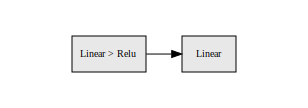

In [17]:
model = torch.nn.Sequential(torch.nn.Linear(inp,hid), 
                            torch.nn.ReLU(),
                            # p = 0.2 -> 20% probability that a neuron will be skipped
                            torch.nn.Dropout(p=0.2),
                            torch.nn.Linear(hid,out))
hl.build_graph(model, torch.zeros([10, inp]))

In [18]:
# quite popular - computional efficient; doesn't take much memory
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [19]:
total_step = len(train_loader)

num_epochs = 10000

for epoch in range(num_epochs+1):
    for i, (features,target) in enumerate(train_loader):
        output = model(features)
        loss = loss_fn(output, target)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if epoch % 2000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10000], Step [1/6], Loss: 26025876.0000
Epoch [1/10000], Step [2/6], Loss: 23783532.0000
Epoch [1/10000], Step [3/6], Loss: 21699914.0000
Epoch [1/10000], Step [4/6], Loss: 21626526.0000
Epoch [1/10000], Step [5/6], Loss: 23873708.0000
Epoch [1/10000], Step [6/6], Loss: 18173314.0000
Epoch [2001/10000], Step [1/6], Loss: 1998349.0000
Epoch [2001/10000], Step [2/6], Loss: 1924463.2500
Epoch [2001/10000], Step [3/6], Loss: 2432155.0000
Epoch [2001/10000], Step [4/6], Loss: 2509760.7500
Epoch [2001/10000], Step [5/6], Loss: 2435564.2500
Epoch [2001/10000], Step [6/6], Loss: 2060085.5000
Epoch [4001/10000], Step [1/6], Loss: 1930197.8750
Epoch [4001/10000], Step [2/6], Loss: 2157007.7500
Epoch [4001/10000], Step [3/6], Loss: 2843136.0000
Epoch [4001/10000], Step [4/6], Loss: 2953223.7500
Epoch [4001/10000], Step [5/6], Loss: 1935349.5000
Epoch [4001/10000], Step [6/6], Loss: 2029014.2500
Epoch [6001/10000], Step [1/6], Loss: 2606799.7500
Epoch [6001/10000], Step [2/6], Loss: 14551

In [20]:
# switch to evaluation mode before we'll test our model - because some of the layers may perform differently based on the mode selected (e.g., dropout and batch normalization layers)

model.eval()

with torch.no_grad():
    y_pred = model(x_test_tensor)

In [21]:
sample = x_test.iloc[45]
sample

registered       3596.000000
holiday             0.000000
weekday             2.000000
weathersit          1.000000
temp                0.794167
atemp               0.739275
season_fall         1.000000
season_spring       0.000000
season_summer       0.000000
season_winter       0.000000
Name: 192, dtype: float64

In [22]:
sample_tensor = torch.tensor(sample.values, dtype=torch.float)
sample_tensor

tensor([3.5960e+03, 0.0000e+00, 2.0000e+00, 1.0000e+00, 7.9417e-01, 7.3927e-01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [23]:
with torch.no_grad():
    y_pred = model(sample_tensor)

print('predicted - ', y_pred.item())
print('actual - ', y_test.iloc[45])

predicted -  4195.5458984375
actual -  cnt    4258
Name: 192, dtype: int64


In [24]:
# let's get all predicted vs. actual data samples
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)

y_pred = y_pred_tensor.detach().numpy()

# 147 predictions
y_pred.shape

(147, 1)

In [25]:
# 147 values that we can compare with
y_test.values.shape

(147, 1)

In [26]:
# np.squeeze -> removes inner dimensions of the actual and predicted values (it's 1 anyway)
compare_df = pd.DataFrame({'actual': np.squeeze(y_test.values), 'predicted': np.squeeze(y_pred)})

compare_df.sample(5)

,actual,predicted
34,3387,3454.292725
11,3272,3457.015625
130,1530,1600.356079
30,4363,4497.923828
44,7384,6958.855469


In [27]:
# evaluate the regression model -> R squared score - how much of the variance in the underlying data is captured by the regression model => higher score = better

sklearn.metrics.r2_score(y_test, y_pred)

0.8689934985451028

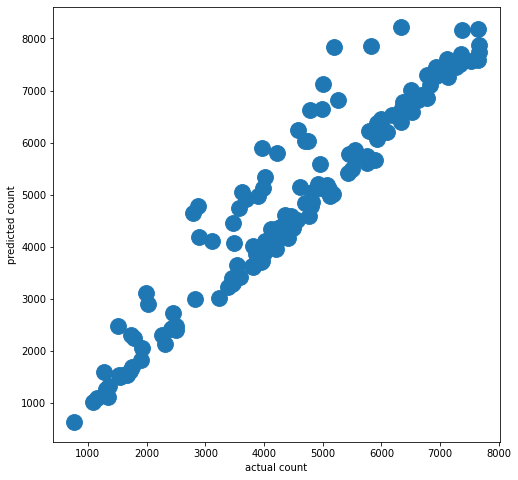

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(y_pred, y_test.values, s=250)

plt.xlabel('actual count')
plt.ylabel('predicted count')

plt.show()